# Modelling

This notebook picks up the previously cleaned and merged data, creates some new and pre-processes features, trains a binary classification model on the trainind set. Final section will evaluate the model.

<a href='#1'>1. Feature Selection<a>  
<a href='#2'>2. Feature Engineering<a>  
<a href='#3'>3. Pre-processing<a>  
<a href='#4'>4. Modelling<a>      
<a href='#5'>5. Feature Importances<a>


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split

# impute
from sklearn.impute import SimpleImputer

# pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# SMOTE
from imblearn.over_sampling import RandomOverSampler 

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, ConfusionMatrixDisplay

## 1. Feature Selection <a id='1'><a>  

In [2]:
df_hi = pd.read_parquet('../data/1_interim/1_merged_data.parquet')
df_hi.head(2)

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,...,post_area_code,postcode_area,postcode_area_name,sal_lower,sal_upper,sal_freq,sal_currency,sal_togbp_rate,sal_toyearly_factor,sal_mid_gbp
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,...,EH,EH,Edinburgh,18109.0,18109.0,yearly,GBP,1.0,1.0,18109.0
1,2.764970e+12,None,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,...,LS,LS,Leeds,16945.0,16945.0,yearly,GBP,1.0,1.0,16945.0


<div class="alert alert-block alert-warning">
<b>Assumption:</b> 
The intended use of the predicitons is to pre-select mortgage customers who are likely to take out a home insurance. Considering the intended business use I assume that information from campaign table won't be available for the next campaign.   
Bacuase information from the mortgage has practical significance, <b>I only consider features from the mortgage table.<b>
</div>

The columns available or can be derived from mortgage dataset are:
- `full_name`,
- `dob`, 
- `town`,
- `paye`,
- `salary_band`,
- `years_with_employer`,
- `months_with_employer`,
- `hours_per_week`,
- `capital_gain`,
- `capital_loss`,
- `new_mortgage`,
- `sex`,
- `religion`,
- `relationship`,
- `race`,
- `native_country`,
- `workclass`,
- `demographic_characteristic`
- `sal_mid_gbp`

The target columns to predict:
- `'created_account'`

In [3]:
# mortgage_cols = []
df_hi.columns

# df_hi['marital_status'].unique()
# df_hi['relationship'].unique()
# df_hi['education'].unique()
# df_hi['job_title'].unique()
# df_hi['workclass'].unique()

Index(['participant_id', 'name_title', 'first_name', 'last_name', 'age',
       'postcode', 'marital_status', 'education', 'job_title',
       'occupation_level', 'education_num', 'familiarity_FB', 'view_FB',
       'interested_insurance', 'company_email', 'created_account', 'full_name',
       'dob', 'town', 'paye', 'salary_band', 'years_with_employer',
       'months_with_employer', 'hours_per_week', 'capital_gain',
       'capital_loss', 'new_mortgage', 'sex', 'religion', 'relationship',
       'race', 'native_country', 'workclass', 'demographic_characteristic',
       'duplicated', 'dob_yr', 'campaign_yr', 'post_area_code',
       'postcode_area', 'postcode_area_name', 'sal_lower', 'sal_upper',
       'sal_freq', 'sal_currency', 'sal_togbp_rate', 'sal_toyearly_factor',
       'sal_mid_gbp'],
      dtype='object')

## Features to include and pre-process

`'created_account'` - target variable - binary classification

`'age'` - numeric, continous (discrete)  
`'sex'` - categorical with 2 values - as boolean 0/1  
`'religion'` - categorical, non-ordinal one-hot encoding   
`'relationship'` - categorical, non-ordinal one-hot encoding  

`'education'` - categorical, ordinal encoded with integers  
`'education_num'`  
`'occupation_level'`  

`'sal_mid_gbp'` - numeric, continous

`'new_mortgage'` - categorical with 2 values - as boolean 0/1  

`years_with_employer` + `months_with_employer` - numerical continous feature as decimal years  
`hours_per_week`

## 2. Feature Engineering  <a id='2'><a>  
- Create a column representing the time spent with employer as a continous value
- Turn target column to 1 (`Yes`) and 0 (`No`)

In [4]:
# Combine time with employer columns
df_hi['time_with_employer'] = df_hi['years_with_employer'] + df_hi['months_with_employer']/12
df_hi[['time_with_employer', 'years_with_employer', 'months_with_employer']].head()

,time_with_employer,years_with_employer,months_with_employer
0,20.500000,20.0,6.0
1,28.083333,28.0,1.0
2,14.416667,14.0,5.0
3,32.500000,32.0,6.0
4,3.500000,3.0,6.0


In [5]:
cat_cols = ['relationship', 'sex', 'religion']
num_cols = ['age', 'education_num', 'occupation_level','time_with_employer', 'hours_per_week']
target_col = 'created_account'

feature_cols = cat_cols + num_cols + [target_col]

df_hi[feature_cols].isna().sum()

relationship          407
sex                   407
religion              407
age                     0
education_num           0
occupation_level        0
time_with_employer    407
hours_per_week        407
created_account         0
dtype: int64

In [6]:
# Convert target
df_hi[target_col] = df_hi[target_col].map({'No': 0, 'Yes': 1})

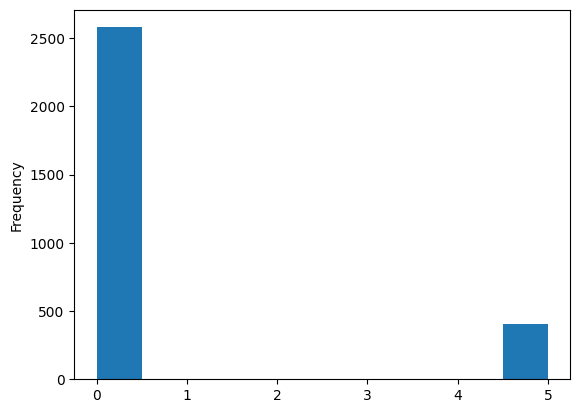

In [7]:
df_hi[feature_cols].isna().sum(1).plot(kind='hist');

In [8]:
df_hi_clean = df_hi.drop(df_hi[df_hi[feature_cols].isna().sum(1)==5].index)
print(df_hi_clean[feature_cols].isna().any().any())
df_hi_clean['created_account'].value_counts()

False


0    2367
1     213
Name: created_account, dtype: int64

In [9]:
df_hi_clean['created_account'].value_counts(normalize=True)

0    0.917442
1    0.082558
Name: created_account, dtype: float64

## 3. Pre-processing <a id='3'><a>  

## Train-test split
This has to be done before fitting any predictors to avoid data-leakage

In [10]:
# Split features and target column
X = df_hi_clean[feature_cols[:-1]]
y = df_hi_clean[feature_cols[-1]]

# Train test split
X_train_nos, X_test, y_train_nos, y_test = train_test_split(X, y, random_state=42)

y_train_nos.value_counts(normalize=True)

0    0.917829
1    0.082171
Name: created_account, dtype: float64

<div class="alert alert-block alert-warning">
<b>Note:</b> 
The target classes are unbalanced; 92% did not take out a home insurance, whilst only 8% took it.<br>
<b> For this exercise I'll try random oversampling and no oversampling
</div>

In [11]:
# Use random oversampler
ros = RandomOverSampler(random_state=42)

X_train_ros, y_train_ros = ros.fit_resample(X_train_nos, y_train_nos)

y_train_ros.value_counts(normalize=True)

0    0.5
1    0.5
Name: created_account, dtype: float64

In [12]:
# Organise the samples into a dicitionary
samples = {'nos': {'X_train': X_train_nos, 'y_train': y_train_nos, 'X_test': X_test, 'y_test': y_test},
           'ros': {'X_train': X_train_ros, 'y_train': y_train_ros, 'X_test': X_test, 'y_test': y_test}}

### Imputation
<div class="alert alert-block alert-warning">
<b>Note:</b> 
TMissing values can be imputed, although they do require some consideration and investigation to see if they are randomly missing or there's something behind it.<br>
Imputing missing values can use a univariate strategy (mean or most frequent) or a multivariate approach where we try to predict the missing values based on other features (MICE of KNN)
<b> For this assignment I drop the missing values
</div>

### ML-Pipline

In [13]:
scaler = StandardScaler()
oh_encoder = OneHotEncoder(drop='first', sparse=False)

# Create a transformer pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', oh_encoder, cat_cols),
        ('num', scaler, num_cols)
    ]
)

## 4. Model Training  <a id='4'><a>  

<div class="alert alert-block alert-warning">
<b>Note:</b> 
Because of the imbalanced dataset, accuracy as a metric to measure how well the model performs is missleading.<br>
A dummy model predicting only 0 would be 92% accurate. At the same time it will not help to identify who is likely to take a home insurance out and would not help us to improve the marketing campaign. <br>
<b> For optimising the marketing campaign, the best evaluation metric to look at is the Precision.<br>Precision measures how many of the predicted positive classes actually are positive:<br>
True Positive / (True Positive + False Positive)<br>
In this case Precision is literally the success rate of the marketing campaign.
    </b>
<br> However, Precision doesn't look at the False Negatives. These would be mortgage holders we think won't take a homeinsurance out but in reality they would. Recall and F1 score takes the false negatives into account as well
</div>

In [14]:
models = [SVC(),
          DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42),
          GaussianNB(),
          LogisticRegression()]

trained_models = []
model_evals = []

for sample in list(samples.keys()):
    for model in models:
        
        # Get training and test datasets
        X_this_train = samples.get(sample).get('X_train')
        y_this_train = samples.get(sample).get('y_train')
        X_this_test = samples.get(sample).get('X_test')
        y_this_test = samples.get(sample).get('y_test')       
        
        # Append Predictor to pipeline 
        ml_pipe = Pipeline(
            steps=[("preprocessor", preprocessor), ("classifier", model)]
        )

        # Fit pipeline
        ml_pipe.fit(X_this_train, y_this_train)
        
        # Use fitted model to predict Train and Test set 
        pred_train = ml_pipe.predict(X_this_train)
        pred_test = ml_pipe.predict(X_this_test)

        # Evaluate Accuracy
        train_accuracy = accuracy_score(y_this_train, pred_train)
        test_accuracy = accuracy_score(y_this_test, pred_test)

        # Evaluate precision score
        train_precision = precision_score(y_this_train, pred_train)
        test_precision = precision_score(y_this_test, pred_test)
        
        # Evaluate F1 score
        train_f1 = f1_score(y_this_train, pred_train)
        test_f1 = f1_score(y_this_test, pred_test)

        # Output
        model_name = model.__repr__().split(':')[0]
        model_evals.append([sample, model_name, 
                            train_accuracy, test_accuracy,
                            train_precision, test_precision,
                            train_f1, test_f1])
        
        trained_models.append(ml_pipe)

/home/gabor/anaconda3/envs/macaroni/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabor/anaconda3/envs/macaroni/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
df_model_performances = pd.DataFrame(model_evals,
                                     columns=['Sampling', 'Predictor',
                                              'Train Accuracy', 'Test Accuracy',
                                              'Train Precision', 'Test Precision',
                                              'Train F1', 'Test F1'])

In [16]:
df_model_performances

,Sampling,Predictor,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train F1,Test F1
0,nos,SVC(),0.917829,0.916279,0.000000,0.000000,0.000000,0.000000
1,nos,DecisionTreeClassifier(random_state=42),1.000000,0.877519,1.000000,0.272727,1.000000,0.275229
2,nos,RandomForestClassifier(random_state=42),1.000000,0.922481,1.000000,0.611111,1.000000,0.305556
3,nos,GaussianNB(),0.349354,0.401550,0.111033,0.121005,0.199619,0.215447
4,nos,LogisticRegression(),0.919897,0.917829,0.540000,0.529412,0.258373,0.253521
5,ros,SVC(),0.885980,0.807752,0.830043,0.275641,0.894887,0.409524
6,ros,DecisionTreeClassifier(random_state=42),1.000000,0.882171,1.000000,0.303571,1.000000,0.309091
7,ros,RandomForestClassifier(random_state=42),1.000000,0.914729,1.000000,0.488372,1.000000,0.432990
8,ros,GaussianNB(),0.597128,0.289922,0.554024,0.102362,0.712014,0.185053
9,ros,LogisticRegression(),0.829392,0.806202,0.804370,0.284848,0.836128,0.429224


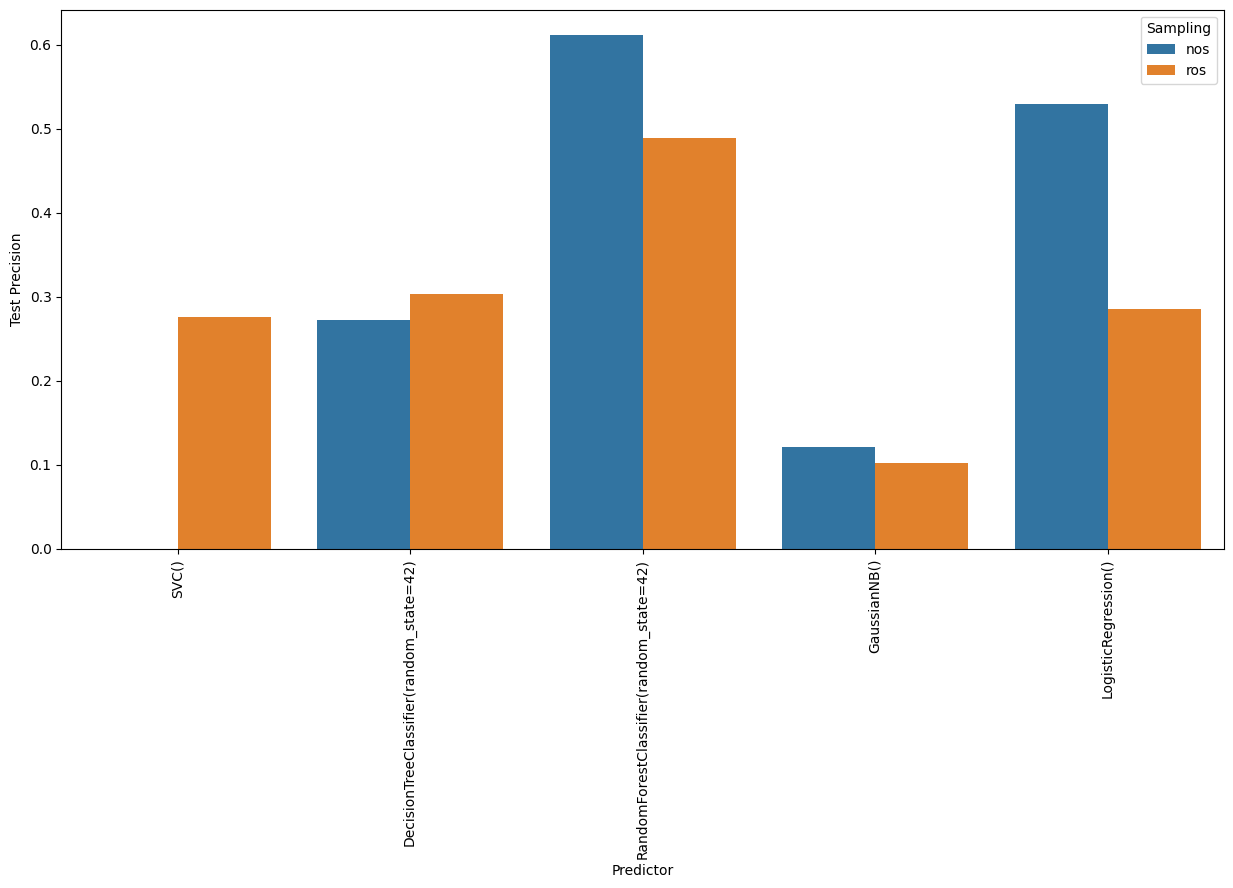

In [17]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(data=df_model_performances,
            x='Predictor',
            y='Test Precision',
            hue='Sampling',
#              palette=cmap.colors,
            ax=ax)

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);

### 4.1 Hyper parameter tuning
We can perform hyper-parameter search on all of the model, although it can be time-consuming.
  
For this assessment I selected the Random Forest Classifier as it was the best performing model in regards to the precision score on the test dataset. However, this model has a perfect accuracy and precision score on the training sets. This can be the symptom of overfitting that would require some further investigation.

In [18]:
best_model_id = df_model_performances['Test Precision'].idxmax()

# Get the model selected
best_model = trained_models[best_model_id]

# Get training and test datasets
sample = df_model_performances['Sampling'].iloc[best_model_id]
X_this_train = samples.get(sample).get('X_train')
y_this_train = samples.get(sample).get('y_train')
X_this_test = samples.get(sample).get('X_test')
y_this_test = samples.get(sample).get('y_test')   

param_grid = [
    {'classifier__criterion': ["gini", "entropy", "log_loss"]}
 ]

clf = GridSearchCV(best_model, param_grid=param_grid, scoring='precision')
clf.fit(X_this_train, y_this_train)

pred_test = clf.best_estimator_.predict(X_this_test)
test_precision = precision_score(y_this_test, pred_test)
print(test_precision)

0.6111111111111112


In [19]:
confusion_matrix(y_this_test, pred_test)

array([[584,   7],
       [ 43,  11]])

In [20]:
precision_score(y_this_test, pred_test)

0.6111111111111112

## Confidence intervals for precision
I am using bootstrapping to calculate the 95% confidence intervall boundaries of the marketing campaign success rate

In [21]:
precisions = []

for _ in range(10_000):
    
    bootsamp_x = X_this_test.sample(frac=1, replace = True)
    bootsamp_y = y_this_test[bootsamp_x.index]
    
    bootsamp_pred = clf.best_estimator_.predict(bootsamp_x)

    bootsamp_precision = precision_score(bootsamp_y, bootsamp_pred)

    precisions.append(bootsamp_precision)

Precision: 0.61
95% Confidence Interval: [0.37 0.83]


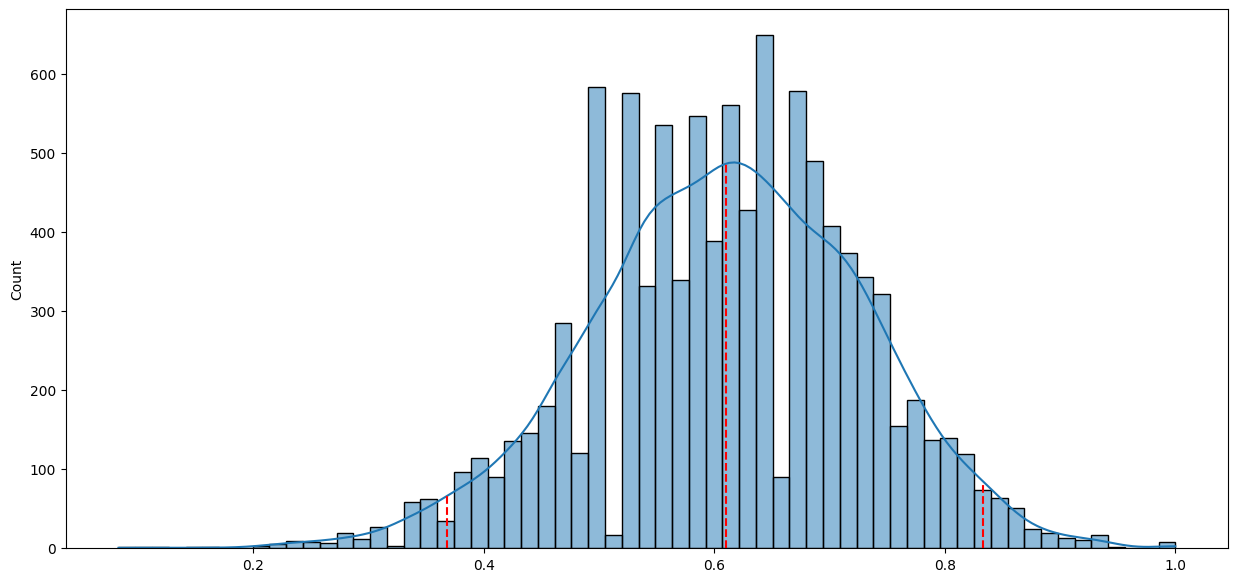

In [36]:
boundaries = np.percentile(precisions, [2.5, 97.5])
mean_precision = np.mean(precisions)

print(f'Precision: {np.round(mean_precision, 2)}')
print(f'95% Confidence Interval: {np.round(boundaries,2)}')

fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(precisions, kde=True, ax=ax)

# get the kde line
line = ax.get_lines()[0]

# interpolate the height values at the CI boundary locations
y_max_b = np.interp(boundaries, line.get_data()[0], line.get_data()[1])
y_max_m = np.interp(mean_precision, line.get_data()[0], line.get_data()[1])


# Add vertical line
ax.vlines(boundaries, ymin=0, ymax=y_max_b, colors='red', linestyles='dashed')
ax.vlines(mean_precision, ymin=0, ymax=y_max_m, colors='red', linestyles='dashed');

## 5. Feature Importances <a id='5'><a>  

In [23]:
forest = clf.best_estimator_[-1]

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

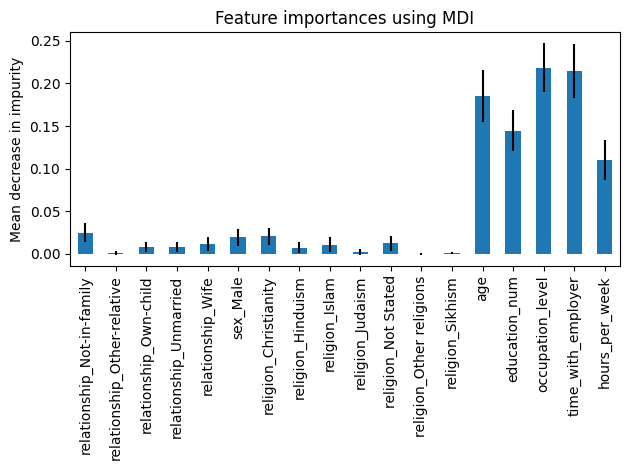

In [24]:
feature_names = preprocessor.transformers_[0][1].get_feature_names_out().tolist() + num_cols

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()